In [1]:
## imports
import numpy as np
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt

from scipy.optimize import minimize 
from scipy.interpolate import griddata
import math
from typing import Union

In [2]:
## qiskit import
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer, transpile
from qiskit.utils import QuantumInstance
from qiskit.quantum_info import Statevector, partial_trace , DensityMatrix
from qiskit.circuit import Parameter, ParameterExpression, ParameterVector
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import optimizers, AmplitudeEstimation, EstimationProblem, AmplificationProblem, Grover, GroverResult, AmplitudeAmplifier
from qiskit.circuit.library import LinearAmplitudeFunction, LinearPauliRotations, PiecewiseLinearPauliRotations, WeightedAdder, GroverOperator
from qiskit_finance.circuit.library import LogNormalDistribution, NormalDistribution
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector


In [3]:
## IBM setup ~
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
# IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
# construct circuit for uncertainty modeler.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm = Aer.get_backend('qasm_simulator')
stv = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')

In [54]:
## helper fucntions ~
def str_to_oracle(pattern: str, name= 'oracle', return_type = "QuantumCircuit" ) -> Union[QuantumCircuit,  Statevector] :
    """ Convert a given string to an oracle circuit
        ARGS:
             pattern: a numpy vector with binarry entries 
        RETURNS: 
                QuantumCircuit   """

    l = len(pattern)
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    oracle_circuit = QuantumCircuit(qr, a, name= name+str(pattern))
    for q in range(l):
        if(pattern[q]=='0'): oracle_circuit.x(qr[q])
    oracle_circuit.x(a)
    oracle_circuit.h(a)
    oracle_circuit.mcx(qr, a)
    oracle_circuit.h(a)
    oracle_circuit.x(a)
    for q in range(l):
        if(pattern[q]=='0'): oracle_circuit.x(qr[q])
    
    #oracle_circuit.barrier()
    if return_type == "QuantumCircuit":
        return oracle_circuit

## oracle prep ~
def generate_oracles(good_states: list) -> QuantumCircuit :
    """ Return a QuantumCircuit that implements the oracles given the good_states
        ARGS:
            good_states: list of good staes, states must be binary strings, Eg. ['00', '11']
        RETURNS:
            QuantumCircuit """

    oracles = [ str_to_oracle(good_state) for good_state in good_states ]
    oracle_circuit = oracles[0]
    for oracle in oracles[1:] :
        oracle_circuit.compose(oracle,  inplace= True)
    
    return oracle_circuit

## state prep circuit ~
def state_prep_circuit(n):
    qreg = QuantumRegister(n)
    state_prep_circuit = QuantumCircuit(qreg, name = "state_prep")
    state_prep_circuit.h(qreg)

    return state_prep_circuit

def plot_histogram_cmpr(counts, figsize= (15,8)):
    return plot_histogram([counts[0], counts[1]], figsize= figsize, legend= ['grover', 'variational'], title= 'Comparison')


In [73]:
## optimisation step ~
def objective(var_params , state_prep_circuit , var_prep_circuit,  grover_circuit, grover_k = 1 , shots= 1024) :
    """ function to compare the performace of the varriational circuit with the grover circuit 
        ARGS: 
            var_params: variational parameters to be used in the variational circuit 
            state_prep_circuit: fucntion to generate circuit for preapring the initial state
            var_preps_circuit: function to generate the variational circuit 
            grover_circuit: circuit that implements the grover operator 
            grover_k: power to which the grover operator is to be raised, is implemented as iterative composition of the 'grover_circuit'
        
        RETURNS: 
                required fidelity between the grover circuit and the variational circuit """
    
    num_state_qubits = grover_circuit.num_qubits - grover_circuit.num_ancillas
    qc = state_prep_circuit(num_state_qubits)
    state_prep_circuit_var = qc.copy()
    state_prep_circuit_grover = qc.copy()

    ## var ~
    var_circuit = var_prep_circuit(num_state_qubits, var_params_input= var_params )
    state_prep_circuit_var.compose( var_circuit, inplace= True )
    
    ## grover ~
    num_ancillas=  grover_circuit.num_ancillas
    ancilla = AncillaRegister(num_ancillas, name= 'ancilla')
    state_prep_circuit_grover.add_register(ancilla)
    for iter in range(grover_k):
            state_prep_circuit_grover.compose( grover_circuit, inplace= True)

    ## measure fidelity using 'Statevector' method ~
    var_statevector = Statevector.from_instruction(state_prep_circuit_var)
    # print(partial_trace(Statevector.from_instruction(state_prep_circuit_grover), [num_state_qubits] )) ##checkflag
    grover_statevector = partial_trace(Statevector.from_instruction(state_prep_circuit_grover), [num_state_qubits] ).to_statevector()
    
    fidelity = -1*np.real(var_statevector.inner(grover_statevector))
    print('fidelity :', fidelity) ##checkflag

    return fidelity


def test_var_vs_grover(var_params , state_prep_circuit , var_prep_circuit,  grover_circuit, grover_k= 1, shots= 1024, plot= True):
    """ function to compare the performace of the varriational circuit with the grover circuit 
        ARGS: 
            var_params: variational parameters to be used in the variational circuit 
            state_prep_circuit: fucntion to generate circuit for preapring the initial state
            var_preps_circuit: function to generate the variational circuit 
            grover_circuit: circuit that implements the grover operator 
            grover_k: power to which the grover operator is to be raised, is implemented as iterative composition of the 'grover_circuit'
        
        RETURNS: None
            plots the histogram of counts obtained from the variational circuit and the grover circuit over the computational basis states. """
    
    num_state_qubits = grover_circuit.num_qubits - grover_circuit.num_ancillas
    creg = ClassicalRegister(num_state_qubits, name= 'creg' )

    qc = state_prep_circuit(num_state_qubits)
    state_prep_circuit_var = qc.copy()
    state_prep_circuit_grover = qc.copy()

    ## var ~
    var_circuit = var_prep_circuit(num_state_qubits, var_params_input= var_params, insert_barriers= True )
    state_prep_circuit_var.compose( var_circuit, inplace= True )
    state_prep_circuit_var.measure_all()

    var_counts = execute(state_prep_circuit_var, backend= qsm, shots= 1024).result().get_counts()

    ## grover ~
    num_ancillas=  grover_circuit.num_ancillas
    qreg_grover = QuantumRegister(num_state_qubits, name= 'qreg')
    state_prep_circuit_grover = QuantumCircuit(qreg_grover).compose(state_prep_circuit_grover)
    ancilla = AncillaRegister(num_ancillas, name= 'ancilla')
    creg = ClassicalRegister(num_state_qubits, name= 'creg')
    state_prep_circuit_grover.add_register(ancilla)
    state_prep_circuit_grover.add_register(creg)
    for iter in range(grover_k):
        state_prep_circuit_grover.compose( grover_circuit, inplace= True)

    state_prep_circuit_grover.measure(qreg_grover, creg )
    grover_counts = execute(state_prep_circuit_grover, backend= qsm, shots= shots).result().get_counts()

    ## plot histogram ~
    # if plot == True:
        

    return [grover_counts, var_counts] , state_prep_circuit_grover, state_prep_circuit_var 


## Variational Quantum Amplitude Estimation Algorithm 
Here we try to implement QAE based on variational quantum circuits as discussed in the paper <insert link >. 

### Step:
Designning a variational circuit to implement $\mathcal{Q}^k$ on a given initial state, where $\mathcal{Q}$ is the grover operator composed as 
$ \mathcal{Q} = - (\mathbb{I} - 2 P_{\psi_0})(\mathbb{I} - 2 P_{good})$. The variational circuit will be constructed out of paramterised $R_y$ gates and $CX$ gates, as discussed in the original paper. 

For implementation we will use pre-defined functions such as  ```AmplificationProblem```, ```Grover``` , ```GroverOperator``` from ```qiskit.circuit.library``` and ```qiskit.algorithms``` module.

##### #2 qubit states

In [6]:
## variational circuit preparation ~
def var_circuit_2qubit(n=2 , var_params_input= 'random' , num_var_params= 4):
    """ Prepare a variational circuit that will optimised to emulate the action of a Grover circuit 
        ARGS: 
            n: no. of qubits [**Prefixed]
            var_params_input: variational parmaters to be used in the circuit. If 'random' the parmaters are intiialised randomly
        RETURNS:
            QuantumCircuit 
    """
        
    qreg = QuantumRegister(n, name= 'qreg')
    var_circuit = QuantumCircuit(qreg, name= "Var_"+str(n))
    
    if var_params_input == 'random' : var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params)
    else: var_params = var_params_input
    
    var_circuit.ry(var_params[0], qreg[1] )
    var_circuit.cx(1,0)
    var_circuit.ry(var_params[1], qreg[1])
    var_circuit.ry(var_params[2], qreg[0])
    var_circuit.cx(1,0)
    var_circuit.ry(var_params[3], qreg[1])

    return var_circuit

In [7]:
## init ~
good_states = ['01']
n = len(good_states[0])
initial_state = None

## create grover operator ~
oracle_circuit = generate_oracles(good_states)
grover_operator = GroverOperator(oracle_circuit, name= "Grover", insert_barriers= False)

In [8]:
num_var_params = 4

## scipy optimisation ~
optimisation_result = minimize(objective, np.random.uniform(low= 0, high= 2*pi, size= num_var_params), (state_prep_circuit, var_circuit_2qubit, grover_operator), 'SLSQP')
print('params: ', optimisation_result.x)

## qiskit-based optimisation ~
# adam = optimizers.ADAM(maxiter=500000)
# optimisation_result = adam.minimize(objective, np.random.uniform(low= 0, high= 2*pi, size= num_var_params) )


/tmp/ipykernel_111875/2331067545.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if var_params_input == 'random' : var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params)


[1.+5.76992334e-33j]
fidelity : -0.8573216959109607
[1.+5.76992334e-33j]
fidelity : -0.8573216926693084
[1.+5.76992334e-33j]
fidelity : -0.8573216926693084
[1.+5.76992334e-33j]
fidelity : -0.8573216942415173
[1.+5.76992334e-33j]
fidelity : -0.8573216979538268
[1.+5.76992334e-33j]
fidelity : -0.9549798324407134
[1.+5.76992334e-33j]
fidelity : -0.9549798307605672
[1.+5.76992334e-33j]
fidelity : -0.9549798307605671
[1.+5.76992334e-33j]
fidelity : -0.9549798315561829
[1.+5.76992334e-33j]
fidelity : -0.9549798338392257
[1.+5.76992334e-33j]
fidelity : -0.9967511332748309
[1.+5.76992334e-33j]
fidelity : -0.9967511335188796
[1.+5.76992334e-33j]
fidelity : -0.9967511335188796
[1.+5.76992334e-33j]
fidelity : -0.9967511331548012
[1.+5.76992334e-33j]
fidelity : -0.996751133800307
[1.+5.76992334e-33j]
fidelity : -0.9983266618765501
[1.+5.76992334e-33j]
fidelity : -0.9983266620477961
[1.+5.76992334e-33j]
fidelity : -0.9983266620477961
[1.+5.76992334e-33j]
fidelity : -0.9983266617887417
[1.+5.7699233

In [9]:
result = test_var_vs_grover(optimisation_result.x, state_prep_circuit, var_circuit_2qubit, grover_operator)
# plot_histogram(result[0])
result[1].draw(), result[2].draw()

/tmp/ipykernel_111875/2331067545.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if var_params_input == 'random' : var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params)


(         ┌───┐┌────┐┌─┐   
  qreg_0: ┤ H ├┤0   ├┤M├───
          ├───┤│    │└╥┘┌─┐
  qreg_1: ┤ H ├┤1 Q ├─╫─┤M├
          └───┘│    │ ║ └╥┘
 ancilla: ─────┤2   ├─╫──╫─
               └────┘ ║  ║ 
  creg: 2/════════════╩══╩═
                      0  1 ,
         ┌───┐              ┌───┐┌────────────┐┌───┐               ░ ┌─┐   
  q30_0: ┤ H ├──────────────┤ X ├┤ Ry(1.5684) ├┤ X ├───────────────░─┤M├───
         ├───┤┌────────────┐└─┬─┘├────────────┤└─┬─┘┌────────────┐ ░ └╥┘┌─┐
  q30_1: ┤ H ├┤ Ry(2.4133) ├──■──┤ Ry(5.4409) ├──■──┤ Ry(6.2823) ├─░──╫─┤M├
         └───┘└────────────┘     └────────────┘     └────────────┘ ░  ║ └╥┘
 meas: 2/═════════════════════════════════════════════════════════════╩══╩═
                                                                      0  1 )

#### #4qubit states

In [100]:
## variational circuit preparation ~
def var_circuit_4qubit(n=4 , var_params_input= 'random' , num_var_layers= 2, insert_barriers= False):
    """ Prepare a variational circuit that will optimised to emulate the action of a Grover circuit 
        ARGS: 
            n: no. of qubits [**Prefixed]
            var_params_input: variational parmaters to be used in the circuit. If 'random' the parmaters are intiialised randomly
            var_layers: no. of times a single variational unit is appended against itself. N.B every variational unit has same structure 

        RETURNS:
            QuantumCircuit 
    """
        
    qreg = QuantumRegister(n, name= 'qreg')
    var_circuit = QuantumCircuit(qreg, name= "Var_"+str(n))
    num_var_params = 10
    
    if var_params_input == 'random' : var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params * var_layers)
    else: var_params = var_params_input
    
    for layer in range(0, num_var_layers):
        # print('layer :', layer) ##checkflag
        if insert_barriers== True: var_circuit.barrier()
        var_circuit.ry(var_params[num_var_params*layer + 0], 1)
        var_circuit.ry(var_params[num_var_params*layer + 1], 3)
  

        var_circuit.cx(1,0)
        var_circuit.ry(var_params[num_var_params*layer + 2], 0)
        var_circuit.ry(var_params[num_var_params*layer + 3], 1)
        var_circuit.cx(1,0)
        var_circuit.cx(3,2)
        var_circuit.ry(var_params[num_var_params*layer + 4], 2)
        var_circuit.ry(var_params[num_var_params*layer + 5], 3)
        var_circuit.cx(3,2)

        var_circuit.ry(var_params[num_var_params*layer + 6], 1)
        var_circuit.cx(1,2)
        var_circuit.ry(var_params[num_var_params*layer + 7], 2)
        var_circuit.cx(2,3)
        var_circuit.ry(var_params[num_var_params*layer + 8], 3)
        var_circuit.cx(3,0)
        var_circuit.ry(var_params[num_var_params*layer + 9], 0)
        var_circuit.cx(0,1)

    return var_circuit

In [101]:
## init ~
good_states = ['1101', '0010']
n = len(good_states[0])
initial_state = None

## create grover operator ~
oracle_circuit = generate_oracles(good_states)
grover_operator_4qubit = GroverOperator(oracle_circuit, name= "Grover", insert_barriers= False)

In [94]:
var_layers = 2
num_var_params = 10 * var_layers
optimisation_result_4qubit = minimize(objective, np.random.uniform(low= 0, high= 2*pi, size= num_var_params), (state_prep_circuit, var_circuit_4qubit, grover_operator_4qubit), 'COBYLA')
optimisation_result_4qubit = minimize(objective, optimisation_result_4qubit.x, (state_prep_circuit, var_circuit_4qubit, grover_operator_4qubit), 'BFGS')
optimisation_result_4qubit = minimize(objective, optimisation_result_4qubit.x, (state_prep_circuit, var_circuit_4qubit, grover_operator_4qubit), 'COBYLA')
# optimisation_result_4qubit = minimize(objective, optimisation_result_4qubit.x, (state_prep_circuit, var_circuit_6qubit, grover_operator_4qubit), 'COBYLA')
print('params: ', optimisation_result_4qubit.x)

/tmp/ipykernel_111875/3978500206.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if var_params_input == 'random' : var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params * var_layers)


[1.-4.45945852e-33j]
fidelity : 0.014379231340260552
[1.-4.45945852e-33j]
fidelity : 0.1635113026336136
[1.-4.45945852e-33j]
fidelity : -0.01703116185212704
[1.-4.45945852e-33j]
fidelity : 0.1087500665095836
[1.-4.45945852e-33j]
fidelity : 0.20035899120090692
[1.-4.45945852e-33j]
fidelity : -0.05578539632081365
[1.-4.45945852e-33j]
fidelity : -0.0030016508428139825
[1.-4.45945852e-33j]
fidelity : 0.2806946993855718
[1.-4.45945852e-33j]
fidelity : -0.0768345269306049
[1.-4.45945852e-33j]
fidelity : 0.04912990835510516
[1.-4.45945852e-33j]
fidelity : -0.202476401563329
[1.-4.45945852e-33j]
fidelity : -0.41699666282612313
[1.-4.45945852e-33j]
fidelity : -0.31064628591652743
[1.-4.45945852e-33j]
fidelity : -0.5260921348757955
[1.-4.45945852e-33j]
fidelity : -0.5394792889685643
[1.-4.45945852e-33j]
fidelity : -0.4601267740850814
[1.-4.45945852e-33j]
fidelity : -0.5616562401298136
[1.-4.45945852e-33j]
fidelity : -0.7115779550905137
[1.-4.45945852e-33j]
fidelity : -0.558267984791839
[1.-4.459

In [98]:
r = test_var_vs_grover(optimisation_result_4qubit.x, state_prep_circuit, var_circuit_4qubit, grover_operator_4qubit)

/tmp/ipykernel_111875/3978500206.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if var_params_input == 'random' : var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params * var_layers)


In [103]:
r[2].draw()

┌───┐ ░               ┌───┐┌─────────────┐┌───┐                   »
q30908_0: ┤ H ├─░───────────────┤ X ├┤ Ry(0.28054) ├┤ X ├───────────────────»
          ├───┤ ░ ┌────────────┐└─┬─┘└┬────────────┤└─┬─┘┌────────────┐     »
q30908_1: ┤ H ├─░─┤ Ry(3.0228) ├──■───┤ Ry(3.2602) ├──■──┤ Ry(1.5709) ├──■──»
          ├───┤ ░ └────────────┘┌───┐ ├────────────┤┌───┐└────────────┘┌─┴─┐»
q30908_2: ┤ H ├─░───────────────┤ X ├─┤ Ry(6.0988) ├┤ X ├──────────────┤ X ├»
          ├───┤ ░ ┌────────────┐└─┬─┘ ├────────────┤└─┬─┘              └───┘»
q30908_3: ┤ H ├─░─┤ Ry(3.1002) ├──■───┤ Ry(2.5264) ├──■─────────────────────»
          └───┘ ░ └────────────┘      └────────────┘                        »
  meas: 4/══════════════════════════════════════════════════════════════════»
                                                                            »
«                                           ┌───┐┌────────────┐      ░ »
«q30908_0: ─────────────────────────────────┤ X ├┤ Ry(6.9507) ├──■───░─»
«                                           └─┬─┘└────────────┘┌─┴─┐ ░ »
«q30908_1: ───────────────────────────────────┼────────────────┤ X ├─░─»
«          ┌────────────┐                     │                └───┘ ░ »
«q30908_2: ┤ Ry(4.7125) ├──■──────────────────┼──────────────────────░─»
«          └────────────┘┌─┴─┐┌────────────┐  │                      ░ »
«q30908_3: ──────────────┤ X ├┤ Ry(3.9466) ├──■──────────────────────░─»
«                        └───┘└────────────┘                         ░ »
«  meas: 4/════════════════════════════════════════════════════════════»
«                                                                      »
«                        ┌───┐┌────────────┐┌───┐                   »
«q30908_0: ──────────────┤ X ├┤ Ry(7.2812) ├┤ X ├───────────────────»
«          ┌────────────┐└─┬─┘├────────────┤└─┬─┘┌────────────┐     »
«q30908_1: ┤ Ry(5.3247) ├──■──┤ Ry(5.8626) ├──■──┤ Ry(7.9107) ├──■──»
«          └────────────┘┌───┐├────────────┤┌───┐└────────────┘┌─┴─┐»
«q30908_2: ──────────────┤ X ├┤ Ry(4.7125) ├┤ X ├──────────────┤ X ├»
«          ┌────────────┐└─┬─┘├───────────┬┘└─┬─┘              └───┘»
«q30908_3: ┤ Ry(3.9377) ├──■──┤ Ry(4.528) ├───■─────────────────────»
«          └────────────┘     └───────────┘                         »
«  meas: 4/═════════════════════════════════════════════════════════»
«                                                                   »
«                                             ┌───┐┌────────────┐      ░ ┌─┐   »
«q30908_0: ───────────────────────────────────┤ X ├┤ Ry(3.1416) ├──■───░─┤M├───»
«                                             └─┬─┘└────────────┘┌─┴─┐ ░ └╥┘┌─┐»
«q30908_1: ─────────────────────────────────────┼────────────────┤ X ├─░──╫─┤M├»
«          ┌──────────────┐                     │                └───┘ ░  ║ └╥┘»
«q30908_2: ┤ Ry(-0.46361) ├──■──────────────────┼──────────────────────░──╫──╫─»
«          └──────────────┘┌─┴─┐┌────────────┐  │                      ░  ║  ║ »
«q30908_3: ────────────────┤ X ├┤ Ry(3.1416) ├──■──────────────────────░──╫──╫─»
«                          └───┘└────────────┘                         ░  ║  ║ »
«  meas: 4/═══════════════════════════════════════════════════════════════╩══╩═»
«                                                                         0  1 »
«                
«q30908_0: ──────
«                
«q30908_1: ──────
«          ┌─┐   
«q30908_2: ┤M├───
«          └╥┘┌─┐
«q30908_3: ─╫─┤M├
«           ║ └╥┘
«  meas: 4/═╩══╩═
«           2  3

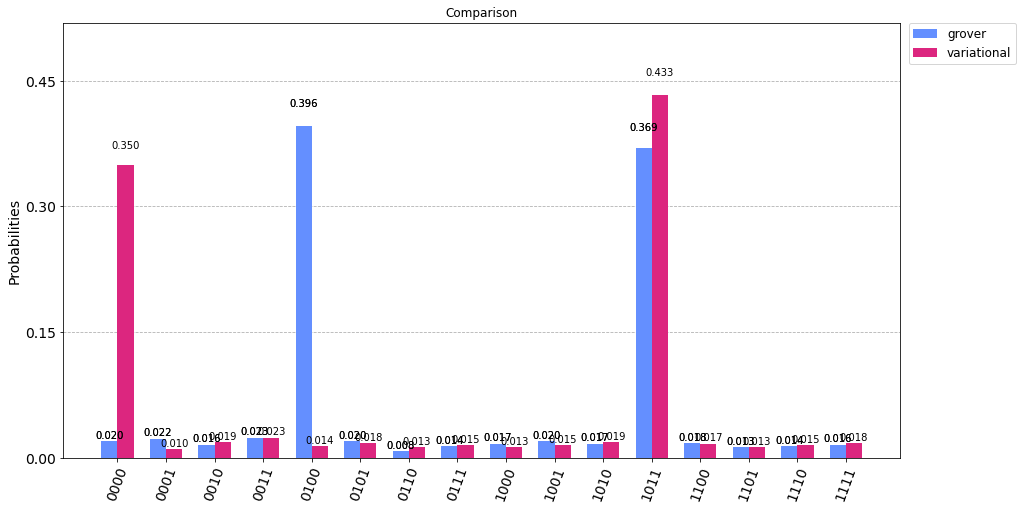

In [99]:
plot_histogram_cmpr(r[0])

#### #6 qubit states

In [82]:
## variational circuit preparation ~
def var_circuit_6qubit(n=6 , var_params_input= 'random' , num_var_layers= 3, insert_barriers= False):
    """ Prepare a variational circuit that will optimised to emulate the action of a Grover circuit 
        ARGS: 
            n: no. of qubits [**Prefixed]
            var_params_input: variational parmaters to be used in the circuit. If 'random' the parmaters are intiialised randomly
            var_layers: no. of times a single variational unit is appended against itself. N.B every variational unit has same structure 

        RETURNS:
            QuantumCircuit 
    """
        
    qreg = QuantumRegister(n, name= 'qreg')
    var_circuit = QuantumCircuit(qreg, name= "Var_"+str(n))
    num_var_params = 15 
    
    if var_params_input == 'random' : var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params * var_layers)
    else: var_params = var_params_input
    
    for layer in range(0, num_var_layers):
        # print('layer :', layer) ##checkflag
        if insert_barriers== True: var_circuit.barrier()
        var_circuit.ry(var_params[num_var_params*layer + 0], 1)
        var_circuit.ry(var_params[num_var_params*layer + 1], 3)
        var_circuit.ry(var_params[num_var_params*layer + 2], 5)

        var_circuit.cx(1,0)
        var_circuit.ry(var_params[num_var_params*layer + 3], 0)
        var_circuit.ry(var_params[num_var_params*layer + 4], 1)
        var_circuit.cx(1,0)
        var_circuit.cx(3,2)
        var_circuit.ry(var_params[num_var_params*layer + 5], 2)
        var_circuit.ry(var_params[num_var_params*layer + 6], 3)
        var_circuit.cx(3,2)
        var_circuit.cx(5,4)
        var_circuit.ry(var_params[num_var_params*layer + 7], 4)
        var_circuit.ry(var_params[num_var_params*layer + 8], 5)
        var_circuit.cx(5,4)

        var_circuit.ry(var_params[num_var_params*layer + 9], 2)
        var_circuit.ry(var_params[num_var_params*layer + 10], 4)

        var_circuit.cx(2,1)
        var_circuit.ry(var_params[num_var_params*layer + 11], 1)
        var_circuit.ry(var_params[num_var_params*layer + 12], 2)
        var_circuit.cx(2,1)
        var_circuit.cx(4,3)
        var_circuit.ry(var_params[num_var_params*layer + 13], 3)
        var_circuit.ry(var_params[num_var_params*layer + 14], 4)
        var_circuit.cx(4,3)

    return var_circuit

In [47]:
## init ~
good_states = ['011001', '001100']
n = len(good_states[0])
initial_state = None

## create grover operator ~
oracle_circuit = generate_oracles(good_states)
grover_operator = GroverOperator(oracle_circuit, name= "Grover", insert_barriers= False)

In [49]:
var_layers = 3
num_var_params = 15 * var_layers
# optimisation_result = minimize(objective, np.random.uniform(low= 0, high= 2*pi, size= num_var_params), (state_prep_circuit, var_circuit_6qubit, grover_operator), 'COBYLA')
optimisation_result = minimize(objective, optimisation_result.x, (state_prep_circuit, var_circuit_6qubit, grover_operator), 'BFGS')
optimisation_result = minimize(objective, optimisation_result.x, (state_prep_circuit, var_circuit_6qubit, grover_operator), 'COBYLA')
# optimisation_result = minimize(objective, optimisation_result.x, (state_prep_circuit, var_circuit_6qubit, grover_operator), 'COBYLA')
print('params: ', optimisation_result.x)

/tmp/ipykernel_111875/4087441371.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if var_params_input == 'random' : var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params * var_layers)


[1.+8.75484369e-33j]
fidelity : 0.04785622580999423
[1.+8.75484369e-33j]
fidelity : 0.03505584933092315
[1.+8.75484369e-33j]
fidelity : -0.004663671830317654
[1.+8.75484369e-33j]
fidelity : -0.0006470690724552236
[1.+8.75484369e-33j]
fidelity : 0.05462493026613719
[1.+8.75484369e-33j]
fidelity : 0.015250356914270697
[1.+8.75484369e-33j]
fidelity : -0.01816167645176112
[1.+8.75484369e-33j]
fidelity : -0.03479535404529452
[1.+8.75484369e-33j]
fidelity : -0.030723215363049228
[1.+8.75484369e-33j]
fidelity : -0.020568902853075024
[1.+8.75484369e-33j]
fidelity : 0.017924426935260078
[1.+8.75484369e-33j]
fidelity : -0.030836965667831846
[1.+8.75484369e-33j]
fidelity : -0.051893264805067646
[1.+8.75484369e-33j]
fidelity : -0.10729191232133864
[1.+8.75484369e-33j]
fidelity : -0.061579581379368364
[1.+8.75484369e-33j]
fidelity : -0.051728823979549234
[1.+8.75484369e-33j]
fidelity : -0.06576189301432303
[1.+8.75484369e-33j]
fidelity : -0.034888399972283504
[1.+8.75484369e-33j]
fidelity : -0.1126

In [50]:
optimal_params_6qubit = optimisation_result.x

In [51]:
r = test_var_vs_grover(optimisation_result.x, state_prep_circuit, var_circuit_6qubit, grover_operator)

/tmp/ipykernel_111875/4087441371.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if var_params_input == 'random' : var_params = np.random.uniform(low= 0, high= 2*pi, size= num_var_params * var_layers)


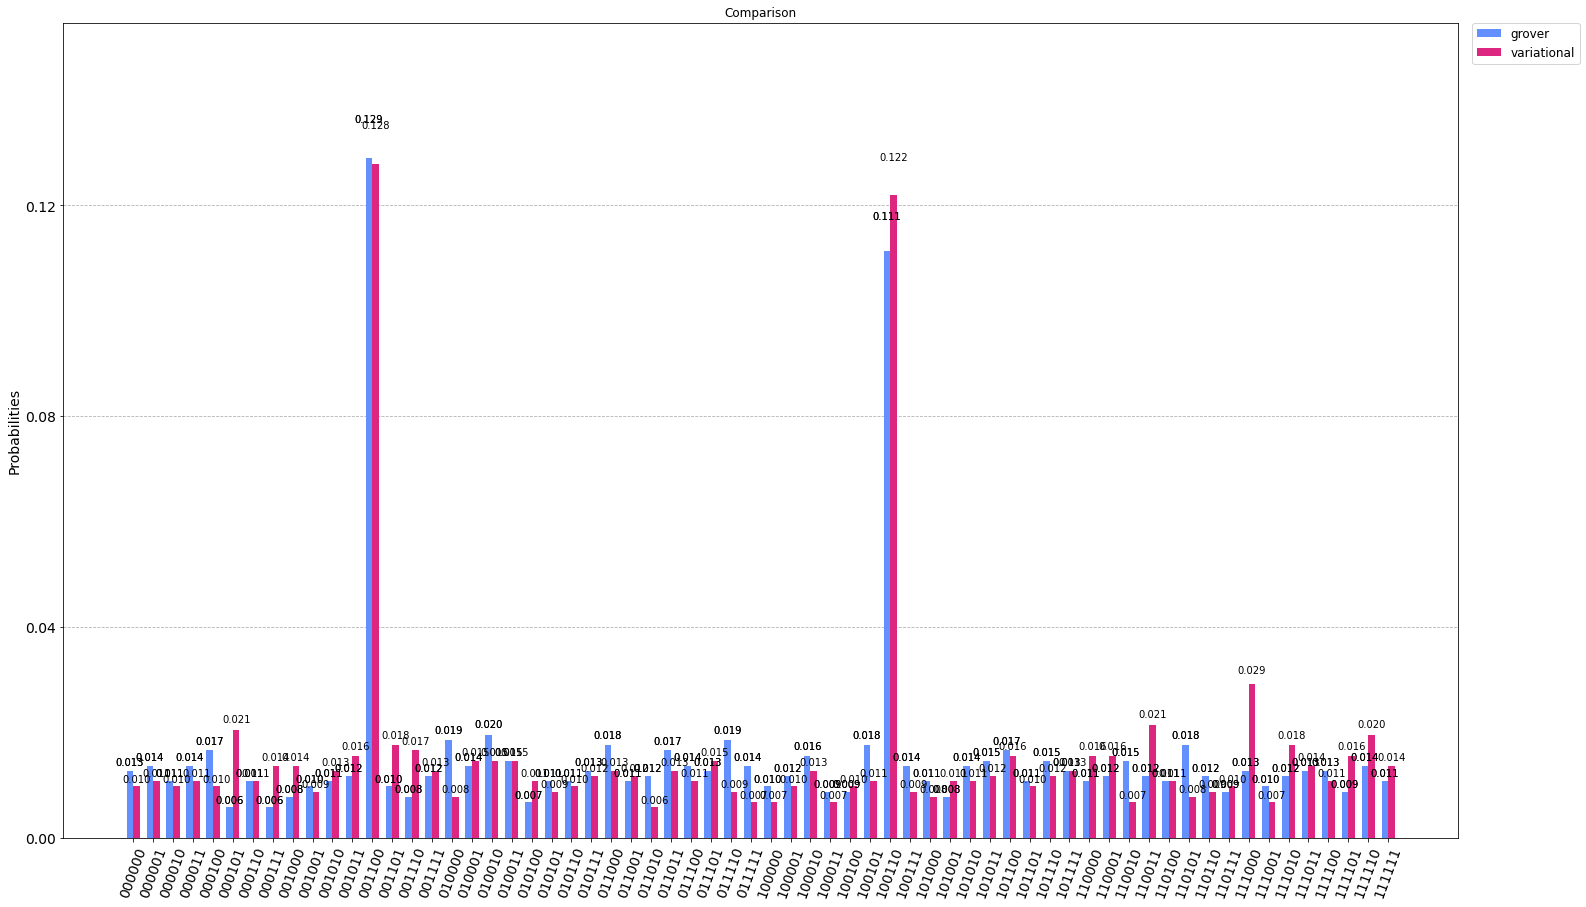

In [55]:
plot_histogram_cmpr(r[0], figsize= (25,15))

In [53]:
r[2].draw()

┌───┐               ┌───┐┌──────────────┐┌───┐                   »
q25978_0: ┤ H ├───────────────┤ X ├┤ Ry(-0.89908) ├┤ X ├───────────────────»
          ├───┤ ┌───────────┐ └─┬─┘└┬────────────┬┘└─┬─┘              ┌───┐»
q25978_1: ┤ H ├─┤ Ry(7.209) ├───■───┤ Ry(3.4826) ├───■────────────────┤ X ├»
          ├───┤ └───────────┘ ┌───┐ ├────────────┤ ┌───┐┌────────────┐└─┬─┘»
q25978_2: ┤ H ├───────────────┤ X ├─┤ Ry(7.2491) ├─┤ X ├┤ Ry(6.2463) ├──■──»
          ├───┤ ┌────────────┐└─┬─┘ ├────────────┤ └─┬─┘└────────────┘┌───┐»
q25978_3: ┤ H ├─┤ Ry(1.6355) ├──■───┤ Ry(1.1793) ├───■────────────────┤ X ├»
          ├───┤ └────────────┘┌───┐ ├────────────┤ ┌───┐┌────────────┐└─┬─┘»
q25978_4: ┤ H ├───────────────┤ X ├─┤ Ry(5.6531) ├─┤ X ├┤ Ry(1.2522) ├──■──»
          ├───┤┌─────────────┐└─┬─┘ ├────────────┤ └─┬─┘├───────────┬┘     »
q25978_5: ┤ H ├┤ Ry(0.85824) ├──■───┤ Ry(3.9597) ├───■──┤ Ry(5.817) ├──────»
          └───┘└─────────────┘      └────────────┘      └───────────┘      »
  meas: 6/═════════════════════════════════════════════════════════════════»
                                                                           »
«                                                  ┌───┐     ┌────────────┐»
«q25978_0: ────────────────────────────────────────┤ X ├─────┤ Ry(3.9351) ├»
«           ┌────────────┐┌───┐┌─────────────┐     └─┬─┘     ├────────────┤»
«q25978_1: ─┤ Ry(5.6517) ├┤ X ├┤ Ry(0.51237) ├───────■───────┤ Ry(3.8791) ├»
«           ├────────────┤└─┬─┘└─────────────┘     ┌───┐     ├────────────┤»
«q25978_2: ─┤ Ry(5.5596) ├──■──────────────────────┤ X ├─────┤ Ry(5.2918) ├»
«          ┌┴────────────┤┌───┐ ┌────────────┐     └─┬─┘     ├────────────┤»
«q25978_3: ┤ Ry(0.68639) ├┤ X ├─┤ Ry(7.8568) ├───────■───────┤ Ry(2.1796) ├»
«          └┬────────────┤└─┬─┘ └───┬───┬────┘ ┌────────────┐└───┬───┬────┘»
«q25978_4: ─┤ Ry(2.0578) ├──■───────┤ X ├──────┤ Ry(2.7005) ├────┤ X ├─────»
«           └────────────┘          └─┬─┘     ┌┴────────────┤    └─┬─┘     »
«q25978_5: ───────────────────────────■───────┤ Ry(0.63389) ├──────■───────»
«                                             └─────────────┘              »
«  meas: 6/════════════════════════════════════════════════════════════════»
«                                                                          »
«              ┌───┐                                                 »
«q25978_0: ────┤ X ├─────────────────────────────────────────────────»
«              └─┬─┘                        ┌───┐      ┌────────────┐»
«q25978_1: ──────■──────────────────────────┤ X ├──────┤ Ry(4.3999) ├»
«              ┌───┐     ┌────────────┐     └─┬─┘      ├────────────┤»
«q25978_2: ────┤ X ├─────┤ Ry(8.2725) ├───────■────────┤ Ry(1.4804) ├»
«              └─┬─┘     └───┬───┬────┘ ┌────────────┐ └───┬───┬────┘»
«q25978_3: ──────■───────────┤ X ├──────┤ Ry(4.1209) ├─────┤ X ├─────»
«          ┌────────────┐    └─┬─┘     ┌┴────────────┴┐    └─┬─┘     »
«q25978_4: ┤ Ry(6.6494) ├──────■───────┤ Ry(-0.85952) ├──────■───────»
«          ├────────────┤              └──────────────┘              »
«q25978_5: ┤ Ry(4.4289) ├────────────────────────────────────────────»
«          └────────────┘                                            »
«  meas: 6/══════════════════════════════════════════════════════════»
«                                                                    »
«                                             ┌───┐      ┌────────────┐»
«q25978_0: ───────────────────────────────────┤ X ├──────┤ Ry(3.2158) ├»
«              ┌───┐      ┌────────────┐      └─┬─┘      ├────────────┤»
«q25978_1: ────┤ X ├──────┤ Ry(1.9698) ├────────■────────┤ Ry(3.0783) ├»
«              └─┬─┘      └───┬───┬────┘┌───────────────┐└───┬───┬────┘»
«q25978_2: ──────■────────────┤ X ├─────┤ Ry(-0.084184) ├────┤ X ├─────»
«          ┌────────────┐     └─┬─┘     └─┬────────────┬┘    └─┬─┘     »
«q25978_3: ┤ Ry(1.8587) ├───────■─────────┤ Ry(2.8366) ├───────■───────»
«          └───┬───┬────┘┌─────────────┐  └───┬───┬